In [45]:
# Chargement des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
import warnings
import importlib


import model_functions; importlib.reload(model_functions)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [46]:
# Chargement des données
df=model_functions.read_data('data.csv')
df

Aperçu des données (7431 lignes, 27 colonnes):
Conversion de 'listing_price': float64 -> float64, valeurs NA créées: 244
Conversion de 'price_ttc': float64 -> float64, valeurs NA créées: 244
Conversion de 'price': float64 -> float64, valeurs NA créées: 244
Conversion de 'size': int64 -> int64, valeurs NA créées: 0
Conversion de 'rooms': float64 -> float64, valeurs NA créées: 14
Conversion de 'bedrooms': float64 -> float64, valeurs NA créées: 14
Conversion de 'bathrooms': float64 -> float64, valeurs NA créées: 14
Conversion de 'parkings': float64 -> float64, valeurs NA créées: 11
Conversion de 'construction_year': float64 -> float64, valeurs NA créées: 4968
Conversion de 'age': float64 -> float64, valeurs NA créées: 4969
Conversion de 'air_conditioning': float64 -> float64, valeurs NA créées: 1863
Conversion de 'central_heating': float64 -> float64, valeurs NA créées: 1863
Conversion de 'swimming_pool': float64 -> float64, valeurs NA créées: 1863
Conversion de 'elevator': float64 -> flo

,source,neighborhood,city,state,transaction,property_type,date,listing_price,suffix,price_ttc,price,size,rooms,bedrooms,bathrooms,parkings,finishing,condition,construction_year,age,air_conditioning,central_heating,swimming_pool,elevator,garden,equipped_kitchen,amenities
0,century 21,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,villa,2/12/2025,1700000.0,TTC,1700000.0,1700000.0,400,7.0,5.0,4.0,1.0,haut standing,bonne condition,2012.0,13.0,1.0,1.0,0.0,0.0,1.0,1.0,Parking+Terrasse+Chauffage Central+Prise lave-...
1,century 21,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,villa,8/24/2024,1580000.0,TTC,1580000.0,1659000.0,600,7.0,5.0,3.0,3.0,moyen standing,excellente condition,NaN,NaN,1.0,1.0,1.0,0.0,1.0,1.0,Terrasse+Chambre de Service+Parking+Chauffage ...
2,tecnocasa,Ain Zaghouan,Ain Zaghouan,Tunis,sale,villa,4/11/2025,1500000.0,TTC,1500000.0,1500000.0,368,0.0,0.0,0.0,0.0,moyen standing,bonne condition,2008.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,century 21,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,appartement,11/17/2023,1200000.0,TTC,1200000.0,1323000.0,256,6.0,4.0,3.0,1.0,haut standing,neuf,2023.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,Piscine+Prise lave-vaisselle+Chauffage Central...
4,century 21,Ain Zaghouan Nord,Ain Zaghouan,Tunis,sale,duplex,11/16/2023,1200000.0,TTC,1200000.0,1323000.0,256,6.0,4.0,3.0,1.0,haut standing,neuf,2023.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,Terrasse+Chambre de Service+Double vitrage+Cam...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7426,tecnocasa,Sousse Corniche,Sousse Ville,Sousse,rent,appartement,3/27/2025,600.0,TTC,600.0,600.0,90,3.0,2.0,1.0,1.0,haut standing,NaN,2024.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Cuisine Equipée
7427,tecnocasa,Sousse Corniche,Sousse Ville,Sousse,rent_furnished,appartement,5/5/2025,600.0,TTC,600.0,600.0,60,1.0,1.0,1.0,0.0,NaN,NaN,2003.0,22.0,1.0,0.0,0.0,0.0,0.0,1.0,"Climatisation, Cuisine Equipée"
7428,tecnocasa,Sousse Corniche,Sousse Ville,Sousse,rent,bureau,4/11/2025,550.0,TTC,550.0,550.0,50,2.0,0.0,1.0,0.0,moyen standing,bonne condition,1956.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7429,remax,Sousse Corniche,Sousse Ville,Sousse,rent,appartement,2/24/2025,500.0,TTC,500.0,500.0,60,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Imputation des Prix
# 1er niveau d'imputation
df['price'] = df.groupby(['neighborhood', 'property_type','transaction'])['price'].transform(
    lambda x: x.fillna(x.mean())
)
df['price_ttc'] = df.groupby(['neighborhood', 'property_type','transaction'])['price_ttc'].transform(
    lambda x: x.fillna(x.mean())
)
# 2ème niveau d'imputation
df['price'] = df.groupby(['city','transaction'])['price'].transform(lambda x: x.fillna(x.mean()))
df['price_ttc'] = df.groupby(['city','transaction'])['price_ttc'].transform(lambda x: x.fillna(x.mean()))
df['listing_price'] = df['listing_price'].fillna(df['price']) # Remplir les valeurs manquantes de 'listing_price' avec la valeur de 'price' si disponible
df['suffix'] = df['suffix'].fillna('TTC') # remplacer suffixe par ttc par defaut
# 3ème niveau d'imputation
df = df[df['price'].notnull()] #éliminer les lignes où 'price' est toujours manquant


null_price_rows = df[df['price'].isna()]
display(null_price_rows)
print(f"Nombre de lignes avec 'price' manquant après imputation : {null_price_rows.shape[0]}") # de 244 prix manquants on passe à 0

# Imputation des variables catégorielles: standing et condition
df=model_functions.impute_condition_simple(df)
df=model_functions.impute_finishing_simple(df)
# Imputation de la variable 'age' et 'construction_year'
df=model_functions.impute_property_year_age(df)
df['construction_year']=2025-df['age']
# Imputation des variables binaires des commodités
df=model_functions.impute_binary_amenities(df,['central_heating','air_conditioning','elevator','swimming_pool','equipped_kitchen','garden'])
# Imputation des variables numériques des pieces, chambres, salles de bain et parkings
df=model_functions.simple_impute_rooms(df)
df=model_functions.simple_impute_rooms(df,'bedrooms')
df=model_functions.simple_impute_rooms(df,'parkings')
df=model_functions.simple_impute_rooms(df,'bathrooms')
df.drop(columns=['amenities'], inplace=True)

In [54]:
df_regression= model_functions.prepare_data_for_regression(df)
df_with_categories=model_functions.create_price_category(df_regression)
df_with_categories

Colonnes exclues: ['source', 'date', 'suffix', 'listing_price', 'price_ttc', 'construction_year']
=== CRÉATION DES CATÉGORIES DE PRIX ===
Filtrage des valeurs aberrantes: 391 lignes supprimées
Calcul des moyennes par marché local (groupement: city, property_type, transaction)

📊 RÉPARTITION DES CATÉGORIES DE PRIX:
----------------------------------------
  Catégorie  Code  Nombre  Pourcentage
 Mal estimé     0    2662         37.8
Bien estimé     1    4378         62.2

📈 STATISTIQUES DÉTAILLÉES PAR CATÉGORIE:
---------------------------------------------

Mal estimé (Code 0):
  • Nombre de biens: 2662
  • Prix moyen: 257260 TND
  • Prix/m² moyen: 1163 TND/m²
  • Ratio moyen: 1.03
  • Taille moyenne: 220 m²
  • Top 3 marchés:
    - Jardins de Carthage - appartement - rent: 152 biens
    - Les berges du Lac - bureau - rent: 135 biens
    - Les berges du Lac - appartement - rent: 114 biens

Bien estimé (Code 1):
  • Nombre de biens: 4378
  • Prix moyen: 268104 TND
  • Prix/m² moyen: 1415

(           neighborhood          city   state     transaction property_type  \
 0     Ain Zaghouan Nord  Ain Zaghouan   Tunis            sale         villa   
 1     Ain Zaghouan Nord  Ain Zaghouan   Tunis            sale         villa   
 2          Ain Zaghouan  Ain Zaghouan   Tunis            sale         villa   
 3     Ain Zaghouan Nord  Ain Zaghouan   Tunis            sale   appartement   
 4     Ain Zaghouan Nord  Ain Zaghouan   Tunis            sale        duplex   
 ...                 ...           ...     ...             ...           ...   
 7035    Sousse Corniche  Sousse Ville  Sousse            rent   appartement   
 7036    Sousse Corniche  Sousse Ville  Sousse  rent_furnished   appartement   
 7037    Sousse Corniche  Sousse Ville  Sousse            rent        bureau   
 7038    Sousse Corniche  Sousse Ville  Sousse            rent   appartement   
 7039              Rtiba       Takelsa  Nabeul            sale         villa   
 
           price  size  rooms  bedroom

=== CRÉATION DES CATÉGORIES DE PRIX ===
Filtrage des valeurs aberrantes: 391 lignes supprimées
Calcul des moyennes par marché local (groupement: city, property_type, transaction)

📊 RÉPARTITION DES CATÉGORIES DE PRIX:
----------------------------------------
  Catégorie  Code  Nombre  Pourcentage
 Mal estimé     0    2662         37.8
Bien estimé     1    4378         62.2

📈 STATISTIQUES DÉTAILLÉES PAR CATÉGORIE:
---------------------------------------------

Mal estimé (Code 0):
  • Nombre de biens: 2662
  • Prix moyen: 257260 TND
  • Prix/m² moyen: 1163 TND/m²
  • Ratio moyen: 1.03
  • Taille moyenne: 220 m²
  • Top 3 marchés:
    - Jardins de Carthage - appartement - rent: 152 biens
    - Les berges du Lac - bureau - rent: 135 biens
    - Les berges du Lac - appartement - rent: 114 biens

Bien estimé (Code 1):
  • Nombre de biens: 4378
  • Prix moyen: 268104 TND
  • Prix/m² moyen: 1415 TND/m²
  • Ratio moyen: 0.98
  • Taille moyenne: 182 m²
  • Top 3 marchés:
    - Jardins de Carth

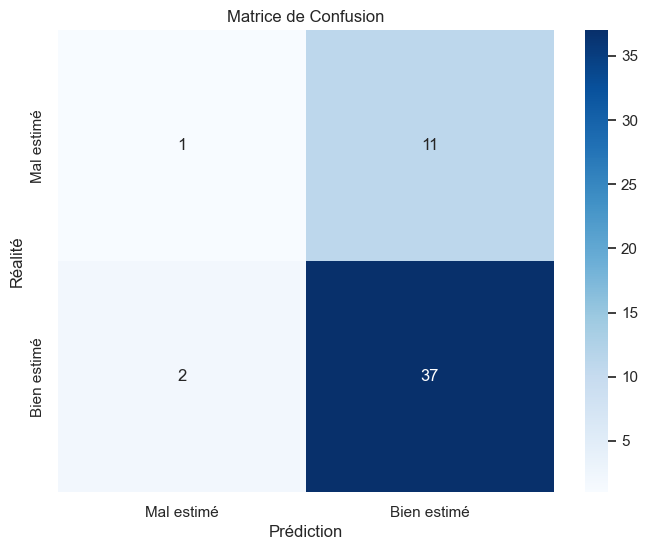

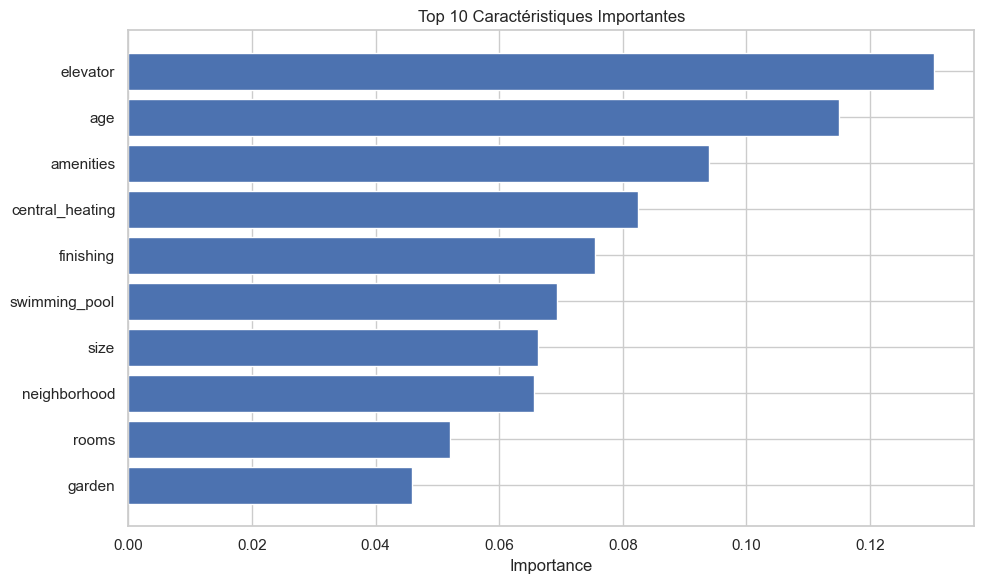

Précision du modèle : 0.745
Nombre d'observations : 51


In [53]:
df_with_categories, category_stats = model_functions.create_price_category(df_regression)

model, results_dict, feature_importance = model_functions.xgboost_price_classification(
    df_with_categories,
    city='La Soukra',
    property_type='appartement',  # Attention à la casse
    transaction='sale'
)

# Visualisation simple avec matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Matrice de confusion
plt.figure(figsize=(8, 6))
cm = results_dict['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Mal estimé', 'Bien estimé'],
            yticklabels=['Mal estimé', 'Bien estimé'])
plt.title('Matrice de Confusion')
plt.ylabel('Réalité')
plt.xlabel('Prédiction')
plt.show()

# 2. Importance des caractéristiques
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['Caractéristique'], top_features['Importance'])
plt.title('Top 10 Caractéristiques Importantes')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. Afficher les résultats texte
print(f"Précision du modèle : {results_dict['test_accuracy']:.3f}")
print(f"Nombre d'observations : {len(results_dict['y_test'])}")